In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb

In [2]:
mc_data = pd.read_json('../datasets/SciFi_200000_Clean_TrackStudy.json')

In [3]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event


In [4]:
mc_hits = mc_data.values

In [5]:
zLays = [7825.99951172, 7895.99951172, 7966.        , 8036.00048828,
       8507.99902344, 8577.99902344, 8647.99902344, 8718.00097656,
       9192.99902344, 9262.99902344, 9332.99902344, 9403.00097656]

max_x = 3182.8356933594
min_x = -3182.8576660156

In [6]:
events = np.unique(mc_hits[:,13])
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

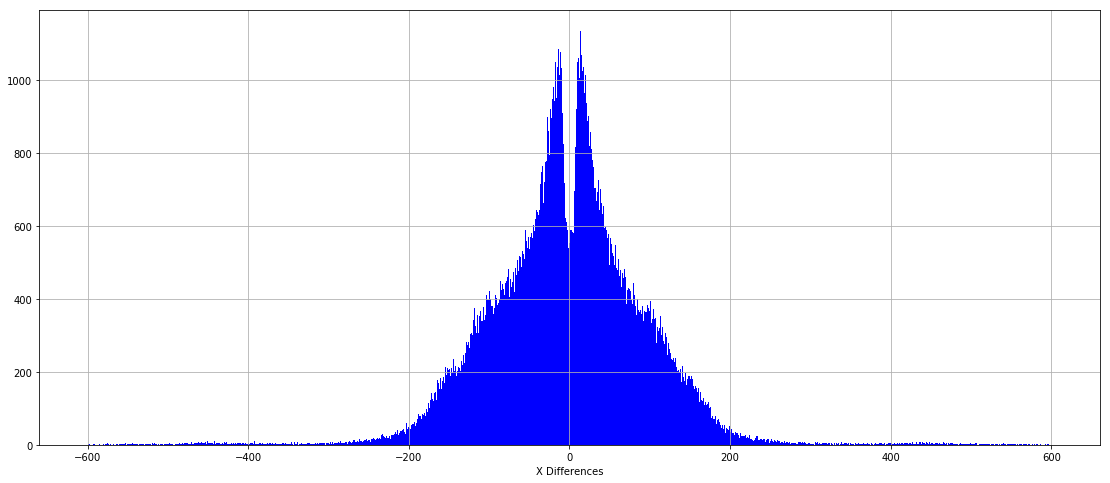

In [9]:
length = mc_hits.shape[0]
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
X_plot = []

for hit in mc_hits:
    
    if (len(hit[5]) > 1):
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        X_plot.append(X_final[0] - X_final[3])

n, bins, patches = plt.hist(X_plot, 1000, facecolor='blue', range=(-600,600))
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

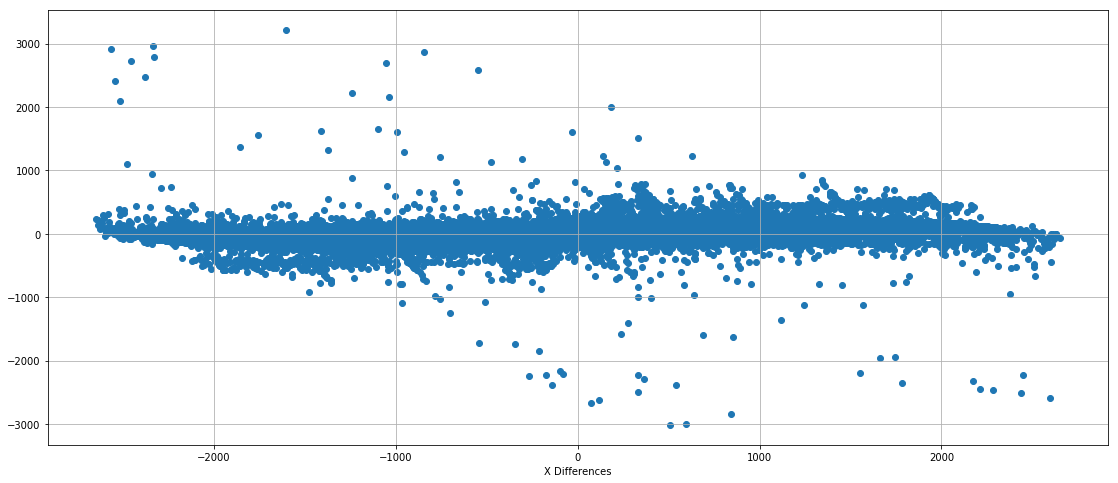

In [10]:
length = mc_hits.shape[0]
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)

X_plot = []
Y_plot = []

for hit in mc_hits:
    
    if (len(hit[5]) > 1):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        
        X_plot.append(X_final[0])
        Y_plot.append((X_final[3] - X_final[0]))
        
plt.scatter(X_plot, Y_plot)
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [12]:
event_threshold = 15840

In [13]:
X_xlayer_model = []
Y_xlayer_model = []

hits_total = mc_hits[mc_hits[:,13] > event_threshold]

for hit in hits_total:
    
    if (len(hit[5]) > 1):
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        
        X_xlayer_model.append([X_final[0], 0])
        Y_xlayer_model.append([X_final[1],X_final[2],X_final[3]])
        
        X_xlayer_model.append([X_final[4], 4])
        Y_xlayer_model.append([X_final[5],X_final[6],X_final[7]])
        
        X_xlayer_model.append([X_final[8], 8])
        Y_xlayer_model.append([X_final[9],X_final[10],X_final[11]])

In [20]:
X_xlayer_model = np.array(X_xlayer_model).reshape(len(X_xlayer_model), 2)
Y_xlayer_model = np.array(Y_xlayer_model).reshape(len(Y_xlayer_model), 3)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_xlayer_model, Y_xlayer_model)

In [22]:
xlayer_model = Sequential()
xlayer_model.add(Dense(12, input_dim=2, kernel_initializer='normal', activation='relu'))
xlayer_model.add(Dense(8, activation='relu'))
xlayer_model.add(Dense(3, activation='linear'))
xlayer_model.summary()
xlayer_model.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12)                36        
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 27        
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = xlayer_model.fit(X_train, y_train, epochs=10, batch_size=200,  verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
307705/307705 [==============================] - 3s 9us/sample - loss: 247402.1593
Epoch 2/10
307705/307705 [==============================] - 2s 8us/sample - loss: 126000.6324
Epoch 3/10
307705/307705 [==============================] - 2s 8us/sample - loss: 126013.4124
Epoch 4/10
307705/307705 [==============================] - 2s 8us/sample - loss: 125962.0987
Epoch 5/10
307705/307705 [==============================] - 2s 8us/sample - loss: 125924.5084
Epoch 6/10
307705/307705 [==============================] - 3s 10us/sample - loss: 125892.9418
Epoch 7/10
307705/307705 [==============================] - 2s 7us/sample - loss: 125844.2567
Epoch 8/10
307705/307705 [==============================] - 3s 8us/sample - loss: 125818.5286
Epoch 9/10
307705/307705 [==============================] - 3s 9us/sample - loss: 125759.4339
Epoch 10/10
307705/307705 [==============================] - 3s 8us/sample - loss: 125734.1389


In [24]:
particles_test_event = mc_hits[mc_hits[:,13] < event_threshold]
print("Event %d Length %d " % ((15800 + i), len(particles_test_event)))

Event 15812 Length 631 


In [25]:
# Create R-tree of hits for the event
event = 0
idx = {}
actual = 0
for hit in particles_test_event:
    if (not hit[13] in idx):
        p = index.Property()
        p.dimension = 2
        idx[hit[13]] = index.Index(properties=p, interleaved=False)
    
    if (len(hit[5]) > 1):
        for i in range(0,len(hit[5])):
            idx[hit[13]].insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i]), float(hit[5][i]))

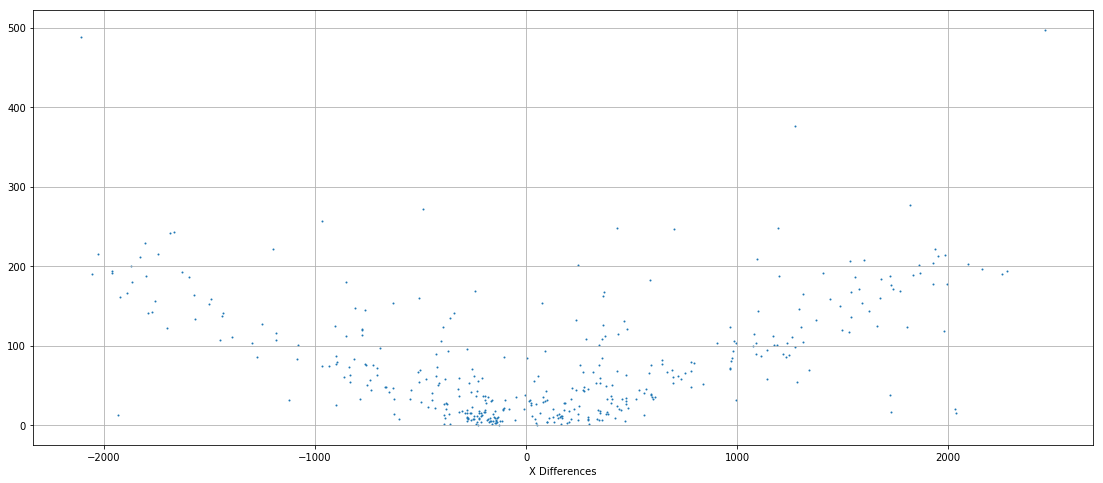

In [31]:
# length = mc_hits.shape[0]
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)

X_plot = []
Y_plot = []

# For each particle of a given event
for particle in particles_test_event:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        X_final = np.zeros(12)
        actual = -1
        found_bool = 0
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
                
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0]
        if (np.abs(X_final[3] - predicted[2]) > 500):
            continue
        
        X_plot.append(X_final[3])
        Y_plot.append(np.abs(X_final[3] - predicted[2]))
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

plt.scatter(X_plot, Y_plot, s=1)
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

In [44]:
#
# Test the NN model by using events not feeded as train 
#

X_plot = []
Y_plot = []

total_found = 0
mean_found = np.zeros(3)
mean_num_found = np.zeros(3)
mean_pos_found = np.zeros(3)
total = 0
long_range = 300

# For each particle of a given event
for particle in particles_test_event:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        X_final = np.zeros(12)
        actual = -1
        found_bool = 0
        
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0][2]
        
        found = list(idx[particle[13]].intersection((predicted - long_range, predicted + long_range, 3, 3),objects='raw'))
        found = sorted(found, key=lambda x: np.abs(x - predicted))[:20]
        
        mean_num_found[2] += len(found)
        for i in range(0,len(found)):
            if (found[i] == X_final[3]):
                mean_found[2] += 1
                mean_pos_found[2] += i
                found_bool += 1
                break
            
        found = list(idx[particle[13]].intersection((predicted - long_range, predicted + long_range, 2, 2),objects='raw'))
        found = sorted(found, key=lambda x: np.abs(x - predicted))[:20]
        
        mean_num_found[1] += len(found)
        for i in range(0,len(found)):
            if (found[i] == X_final[2]):
                mean_found[1] += 1
                mean_pos_found[1] += i
                found_bool += 1
                break
            
        found = list(idx[particle[13]].intersection((predicted - long_range, predicted + long_range, 1, 1),objects='raw'))
        found = sorted(found, key=lambda x: np.abs(x - predicted))[:20]
        
        mean_num_found[0] += len(found)
        for i in range(0,len(found)):
            if (found[i] == X_final[1]):
                mean_found[0] += 1
                mean_pos_found[0] += i
                found_bool += 1
                break
            
        if (found_bool == 3):
            total_found += 1
        total += 1

print("Mean found 1: %f" % (mean_found[0]/total))
print("Mean total found 1: %f" % (mean_num_found[0]/total))
print("Mean pos found 1: %f" % (mean_pos_found[0]/total))

print("\nMean found 2: %f" % (mean_found[1]/total))
print("Mean total found 2: %f" % (mean_num_found[1]/total))
print("Mean pos found 2: %f" % (mean_pos_found[1]/total))

print("\nMean found 3: %f" % (mean_found[2]/total))
print("Mean total found 3: %f" % (mean_num_found[2]/total))
print("Mean pos found 3: %f" % (mean_pos_found[2]/total))

print("\nMean Total Found: %f" % (total_found/total))

Mean found 1: 0.804819
Mean total found 1: 18.040964
Mean pos found 1: 3.178313

Mean found 2: 0.855422
Mean total found 2: 18.195181
Mean pos found 2: 4.257831

Mean found 3: 0.891566
Mean total found 3: 18.209639
Mean pos found 3: 4.809639

Mean Total Found: 0.713253


In [ ]:
hits_total = mc_hits[mc_hits[:,13] < event_threshold + 20]
print("Total hits with threshold %d" % (len(hits_total)))
event = 0
idx = {}
actual = 0
for hit in hits_total:
    if (not hit[13] in idx):
        p = index.Property()
        p.dimension = 2
        idx[hit[13]] = index.Index(properties=p, interleaved=False)
    
    if (len(hit[5]) > 1):
        for i in range(0,len(hit[5])):
            idx[hit[13]].insert(int(hit[4][i]), (float(hit[5][i]), float(hit[5][i]), hit[8][i], hit[8][i]), float(hit[5][i]))

In [ ]:
X_classifier = []
Y_classifier = []
total = 0
mean_found = 0
mean_pos = 0

for particle in hits_total:
    
    if (len(particle[5]) > 1):
        
        # Extract only 12 hits, as some of them are really close
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
            
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,2))[0][0])
        found = list(idx[particle[13]].intersection((predicted - long_range, predicted + long_range, 3, 3), objects='raw'))
        found = sorted(np.unique(found), key=lambda x: np.abs(x - predicted))[:20]
        
        mean_pos += len(found)
        for i in range(0,len(found)):
            if (found[i] == X_final[3]):
                mean_found += 1
                X_classifier.append([found[i], X_final[0]])
                Y_classifier.append(1)
                if (i == 0):
                    if (i == len(found) - 1):
                        continue
                    X_classifier.append([found[i + 1], X_final[0]])
                    Y_classifier.append(0)
                else:
                    X_classifier.append([found[i - 1], X_final[0]])
                    Y_classifier.append(0)
        total += 1

print("Mean found %f" % (mean_found/total))
print("Mean found %f" % (mean_pos/total))
print("Total %d" % total)

In [ ]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
model.add(Dense(12, activation='relu', input_dim=2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X_classifier), np.array(Y_classifier))

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1)

In [ ]:
score, acc = model.evaluate(X_test, y_test, batch_size=25)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
import xgboost as xgb

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_classifier, np.array(Y_classifier))

In [ ]:
train = xgb.DMatrix(data=np.array(X_train).reshape(-1,1),label=np.array(y_train).reshape(-1,1))
test = xgb.DMatrix(data=np.array(X_test).reshape(-1,1),label=np.array(y_test).reshape(-1,1))

In [ ]:
param = {}

# Booster parameters
param['eta']              = 0.1 # learning rate
param['max_depth']        = 20  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 1 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 200  # number of trees to make

In [ ]:
booster = xgb.train(param,train,num_boost_round=num_trees)

In [ ]:
print(booster.eval(test))

In [ ]:
predictions = booster.predict(test)

In [ ]:
# plot all predictions (both signal and background)
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(predictions[test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Corrent');
plt.hist(predictions[~(test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Incorrect');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

In [ ]:
xgb.plot_importance(booster,grid=False);